In [1]:
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from alpaca_keys import API_KEY, SECRET_KEY
import pandas as pd

In [2]:
client = StockHistoricalDataClient(api_key=API_KEY, secret_key=SECRET_KEY)

In [17]:
def get_stock_data(ticker: str, start_date: str, end_date: str, feed: str = "iex") -> pd.DataFrame:
    """
    Fetch 1-minute historical bars for a given stock and date range.
    
    Args:
        ticker (str): Stock symbol (e.g. "TSLA")
        start_date (str): Start date in YYYY-MM-DD
        end_date (str): End date in YYYY-MM-DD (should be next day to cover full date)
        feed (str): "iex" for free, "sip" for full-depth accounts

    Returns:
        pd.DataFrame: Clean OHLCV data with timestamp
    """
    # Connect to Alpaca
    client = StockHistoricalDataClient(api_key=API_KEY, secret_key=SECRET_KEY)

    # Create the request
    request_params = StockBarsRequest(
        symbol_or_symbols=[ticker],
        timeframe=TimeFrame.Minute,
        start=start_date,
        end=end_date,
        feed=feed
    )

    # Get data
    bars = client.get_stock_bars(request_params).df

    if bars.empty:
        print(f" No data returned for {ticker} from {start_date} to {end_date}.")
        return pd.DataFrame()

    # Clean it up
    df = bars.copy()
    df.reset_index(inplace=True)
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = df.columns.get_level_values(1)

    return df

In [27]:
import ta

def add_indicators(df):
    """
    Adds EMA, VWAP, RSI, and MACD indicators to the given DataFrame.

    Args:
        df (pd.DataFrame): Stock data with OHLCV and timestamp

    Returns:
        pd.DataFrame: Same DataFrame with indicators added as new columns
    """

    # Ensure required columns exist
    required_cols = {'high', 'low', 'close', 'volume'}
    if not required_cols.issubset(df.columns):
        raise ValueError(f"Missing columns in input DataFrame: {required_cols - set(df.columns)}")

    # EMAs
    df['ema_5'] = ta.trend.ema_indicator(df['close'], window=5)
    df['ema_9'] = ta.trend.ema_indicator(df['close'], window=9)
    df['ema_20'] = ta.trend.ema_indicator(df['close'], window=20)
    df['ema_30'] = ta.trend.ema_indicator(df['close'], window=30)
    df['ema_50'] = ta.trend.ema_indicator(df['close'], window=50)
    df['ema_75'] = ta.trend.ema_indicator(df['close'], window=75)
    df['ema_100'] = ta.trend.ema_indicator(df['close'], window=100)
    df['ema_150'] = ta.trend.ema_indicator(df['close'], window=150)
    df['ema_200'] = ta.trend.ema_indicator(df['close'], window=200)

    # Feature engineering Trend & Slope Features. These help measure trend strength and reversals.
    df['price_ema9_dist'] = (df['close'] - df['ema_9']) / df['ema_9']
    df['ema9_ema20_dist'] = (df['ema_9'] - df['ema_20']) / df['ema_20']
    df['ema_slope_9'] = df['ema_9'].diff()
    df['ema_slope_20'] = df['ema_20'].diff()

    # Bollinger Bands
    bb = ta.volatility.BollingerBands(close=df['close'], window=20, window_dev=2)
    df['bb_bbm'] = bb.bollinger_mavg()
    df['bb_bbh'] = bb.bollinger_hband()
    df['bb_bbl'] = bb.bollinger_lband()
    df['bb_width'] = bb.bollinger_wband()  # Width = high - low band
    df['bb_close_above'] = df['close'] > df['bb_bbh']
    df['bb_close_below'] = df['close'] < df['bb_bbl']

    # Momentum & Volume Flow
    # Stochastic RSI
    df['stoch_rsi'] = ta.momentum.stochrsi(df['close'], window=14)
    
    # Williams %R
    df['williams_r'] = ta.momentum.williams_r(df['high'], df['low'], df['close'], lbp=14)
    
    # Money Flow Index (MFI)
    df['mfi'] = ta.volume.money_flow_index(df['high'], df['low'], df['close'], df['volume'], window=14)
    
    # On-Balance Volume
    df['obv'] = ta.volume.on_balance_volume(df['close'], df['volume'])

    # Price Action Features
    df['candle_body'] = df['close'] - df['open']
    df['candle_range'] = df['high'] - df['low']
    df['upper_wick'] = df['high'] - df[['close', 'open']].max(axis=1)
    df['lower_wick'] = df[['close', 'open']].min(axis=1) - df['low']
    df['is_green'] = (df['close'] > df['open']).astype(int)

    # VWAP
    vwap_calc = ta.volume.VolumeWeightedAveragePrice(
        high=df['high'], low=df['low'], close=df['close'], volume=df['volume']
    )
    df['vwap'] = vwap_calc.vwap

    # RSI
    df['rsi_14'] = ta.momentum.rsi(df['close'], window=14)

    # MACD
    macd_calc = ta.trend.MACD(df['close'])
    df['macd'] = macd_calc.macd()
    df['macd_signal'] = macd_calc.macd_signal()
    df['macd_diff'] = macd_calc.macd_diff()

    # add lag features
    for col in ['close', 'volume', 'rsi_14', 'macd_diff']:
        df[f'{col}_lag1'] = df[col].shift(1)
        df[f'{col}_lag2'] = df[col].shift(2)

    return df

    return df

In [28]:
df = get_stock_data("U", "2025-07-16", "2025-07-17")

In [29]:
df.head()

,symbol,timestamp,open,high,low,close,volume,trade_count,vwap
0,U,2025-07-16 13:30:00+00:00,32.180,32.530,32.165,32.45,20289.0,105.0,32.357702
1,U,2025-07-16 13:31:00+00:00,32.475,33.260,32.475,33.19,24591.0,192.0,32.934437
2,U,2025-07-16 13:32:00+00:00,33.160,33.410,32.930,32.93,7736.0,85.0,33.231991
3,U,2025-07-16 13:33:00+00:00,32.840,33.070,32.840,32.87,3586.0,36.0,33.007767
4,U,2025-07-16 13:34:00+00:00,32.930,32.935,32.680,32.77,3482.0,28.0,32.798710


In [31]:
df = add_indicators(df)
df.head()

,symbol,timestamp,open,high,low,close,volume,trade_count,vwap,ema_5,...,macd_signal,macd_diff,close_lag1,close_lag2,volume_lag1,volume_lag2,rsi_14_lag1,rsi_14_lag2,macd_diff_lag1,macd_diff_lag2
0,U,2025-07-16 13:30:00+00:00,32.180,32.530,32.165,32.45,20289.0,105.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,U,2025-07-16 13:31:00+00:00,32.475,33.260,32.475,33.19,24591.0,192.0,NaN,NaN,...,NaN,NaN,32.45,NaN,20289.0,NaN,NaN,NaN,NaN,NaN
2,U,2025-07-16 13:32:00+00:00,33.160,33.410,32.930,32.93,7736.0,85.0,NaN,NaN,...,NaN,NaN,33.19,32.45,24591.0,20289.0,NaN,NaN,NaN,NaN
3,U,2025-07-16 13:33:00+00:00,32.840,33.070,32.840,32.87,3586.0,36.0,NaN,NaN,...,NaN,NaN,32.93,33.19,7736.0,24591.0,NaN,NaN,NaN,NaN
4,U,2025-07-16 13:34:00+00:00,32.930,32.935,32.680,32.77,3482.0,28.0,NaN,32.794198,...,NaN,NaN,32.87,32.93,3586.0,7736.0,NaN,NaN,NaN,NaN


In [35]:
import matplotlib.dates as mdates

def plot_intraday_price(df, price_col='close', title='Intraday Price Chart'):
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    plt.figure(figsize=(14, 6))
    plt.plot(df['timestamp'], df[price_col], label=price_col.title(), linewidth=2)

    # Format the x-axis to show HH:MM
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # or MinuteLocator if very granular

    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.grid(True)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [43]:
df['timestamp'] = pd.to_datetime(df['timestamp'], utc=True)
df['timestamp'] = df['timestamp'].dt.tz_convert('US/Eastern')

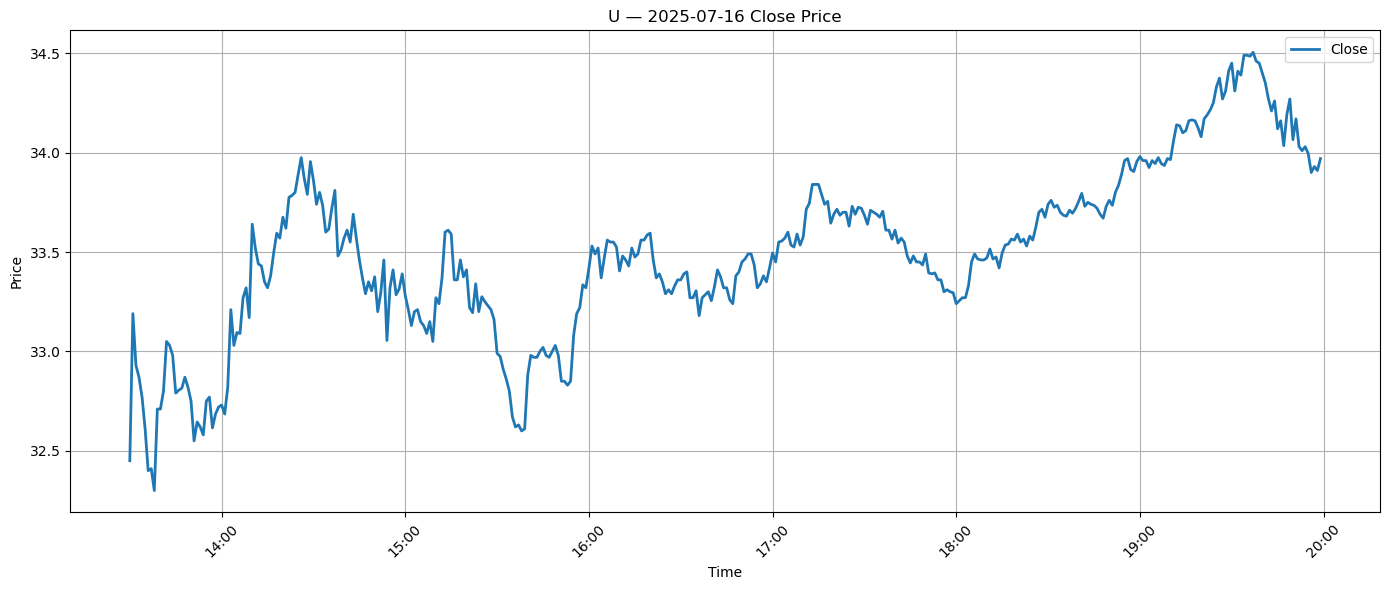

In [44]:
plot_intraday_price(df, price_col='close', title='U — 2025-07-16 Close Price')

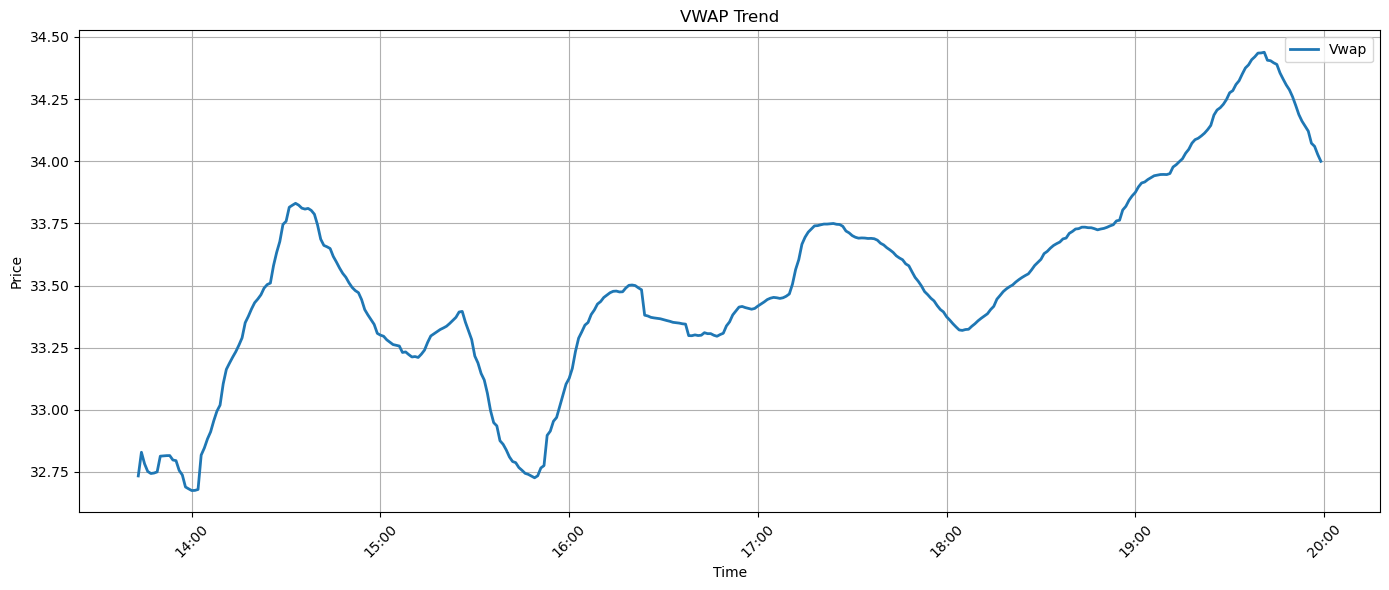

In [45]:
plot_intraday_price(df, price_col='vwap', title='VWAP Trend')

In [46]:
def add_local_high_low_flags(df, price_col='close', window_minutes=120):
    """
    Adds boolean flags to indicate whether each price point is a local high or low
    in a rolling time window (default: 2 hours).

    Args:
        df (pd.DataFrame): DataFrame with timestamp and price_col
        price_col (str): Column to check highs/lows (default 'close')
        window_minutes (int): Rolling window in minutes (default 120)

    Returns:
        pd.DataFrame: Original df with 'is_2h_high' and 'is_2h_low' columns added
    """
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])  # ensure datetime

    # Set timestamp as index to use time-based rolling
    df = df.set_index('timestamp')

    # Rolling window = ±1 hour around current timestamp → total 2 hours
    window = f'{window_minutes}min'

    # Check local highs/lows in the rolling window centered on each point
    rolling_max = df[price_col].rolling(window=window, center=True).max()
    rolling_min = df[price_col].rolling(window=window, center=True).min()

    df['is_2h_high'] = df[price_col] == rolling_max
    df['is_2h_low'] = df[price_col] == rolling_min

    # Reset index to restore original format
    return df.reset_index()


In [48]:
df_with_extremes = add_local_high_low_flags(df, price_col='close', window_minutes=120)
df_with_extremes.head()

,timestamp,symbol,open,high,low,close,volume,trade_count,vwap,ema_5,...,close_lag1,close_lag2,volume_lag1,volume_lag2,rsi_14_lag1,rsi_14_lag2,macd_diff_lag1,macd_diff_lag2,is_2h_high,is_2h_low
0,2025-07-16 09:30:00-04:00,U,32.180,32.530,32.165,32.45,20289.0,105.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False
1,2025-07-16 09:31:00-04:00,U,32.475,33.260,32.475,33.19,24591.0,192.0,NaN,NaN,...,32.45,NaN,20289.0,NaN,NaN,NaN,NaN,NaN,False,False
2,2025-07-16 09:32:00-04:00,U,33.160,33.410,32.930,32.93,7736.0,85.0,NaN,NaN,...,33.19,32.45,24591.0,20289.0,NaN,NaN,NaN,NaN,False,False
3,2025-07-16 09:33:00-04:00,U,32.840,33.070,32.840,32.87,3586.0,36.0,NaN,NaN,...,32.93,33.19,7736.0,24591.0,NaN,NaN,NaN,NaN,False,False
4,2025-07-16 09:34:00-04:00,U,32.930,32.935,32.680,32.77,3482.0,28.0,NaN,32.794198,...,32.87,32.93,3586.0,7736.0,NaN,NaN,NaN,NaN,False,False


In [49]:
import matplotlib.pyplot as plt

def plot_price_with_highs_lows(df, price_col='close', title='Price with 2H High/Low Flags'):
    """
    Plots price over time and marks 2-hour high/low points with triangle markers.

    Args:
        df (pd.DataFrame): Must include 'timestamp', price_col, 'is_2h_high', and 'is_2h_low'
        price_col (str): Column to plot as price
        title (str): Plot title
    """
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Plot price line
    plt.figure(figsize=(14, 6))
    plt.plot(df['timestamp'], df[price_col], label='Price', color='blue')

    # Plot local highs
    highs = df[df['is_2h_high']]
    plt.scatter(highs['timestamp'], highs[price_col], color='green', marker='^', s=100, label='2H High')

    # Plot local lows
    lows = df[df['is_2h_low']]
    plt.scatter(lows['timestamp'], lows[price_col], color='red', marker='v', s=100, label='2H Low')

    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Price")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

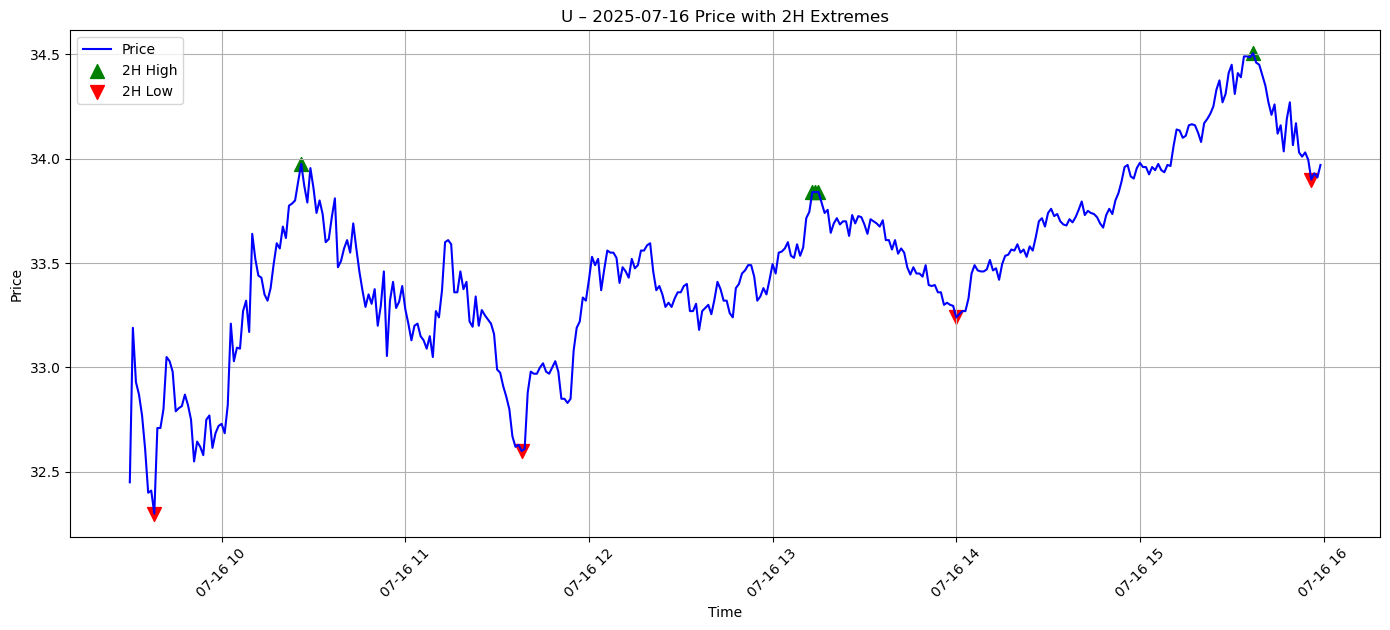

In [50]:
plot_price_with_highs_lows(df_with_extremes, price_col='close', title='U – 2025-07-16 Price with 2H Extremes')

In [52]:
def add_local_high_low_flags(df, window_minutes=120):
    """
    Adds boolean flags for whether a given row is the high or low of a rolling time window.
    Assumes `timestamp` is sorted and in datetime format, and `close` column exists.
    """
    df = df.copy()
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    df = df.set_index('timestamp')

    rolling_window = f'{window_minutes}min'
    df['is_2h_high'] = df['close'] == df['close'].rolling(rolling_window).max()
    df['is_2h_low'] = df['close'] == df['close'].rolling(rolling_window).min()

    # Reset index for consistency
    return df.reset_index()

# Add the flags
df = add_local_high_low_flags(df)

In [53]:
print(df[['timestamp', 'close', 'is_2h_high', 'is_2h_low']].dropna().head())

                  timestamp  close  is_2h_high  is_2h_low
0 2025-07-16 09:30:00-04:00  32.45        True       True
1 2025-07-16 09:31:00-04:00  33.19        True      False
2 2025-07-16 09:32:00-04:00  32.93       False      False
3 2025-07-16 09:33:00-04:00  32.87       False      False
4 2025-07-16 09:34:00-04:00  32.77       False      False


In [54]:
df.to_csv("full_feature_data.csv", index=False)